# Removing lens distortion effects from an image

If you need to remove lens distortion effects from a whole image, you need to use dense remapping. Essentially, the undistortion algorithm warps and compresses the image in a way to compensate for lens effects, but compression leads to blank regions appearing. This recipe tells you how to undistort images and remove empty regions from the undistorted image.

`cv2.undistort` removes lenses distortion from the image. It takes the following arguments: the image to undistort, the camera matrix, the distortion coefficients array, an object to store the undistorted image, and an optimal camera matrix. The last two arguments are optional. The function returns the undistorted image. If you missed the last parameter of `cv2.undistort`, the resulting image will contain empty (of black color) regions. The optimal camera matrix argument allows you to get the image without these artifacts, but we need a way to compute this optimal camera matrix, and OpenCV serves it.

`cv2.getOptimalNewCameraMatrix` creates an optimal camera matrix to get rid of black regions on the undistorted image. It takes the camera matrix, distortion coefficients, the original image size in (width, height) format, the alpha factor, the resulting image size (again in (width, height) format), and a Boolean flag to set the principal camera point of the camera in the center of the output image. The last two arguments are optional. The alpha factor is a double value in range $[0, 1]$ and it shows the degree of removing empty regions: $0$ means complete removal and, as a consequence, loss of some portion of image pixels, while $1$ means preserving all the image pixels along with the empty regions. If you don't set the output image size, it is set to the same as the input image's dimensions.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    #plt.gca().invert_yaxis() plt.gca().invert_xaxis()
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S09\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s09\env

d:\html_doc\program\opencv\packt\s09\env\lib\site-packages
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\pip-20.1-py3.8.egg
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S09\env


------  data/pinhole_calib/img_00.png    Shape(480, 640, 3) image_orig: uint8
[[44 44 44] [42 42 42] [42 42 42] [43 43 43] [41 45 49] [41 45 49] [43 47 48] ]
[[44 44 44] [44 44 44] [42 41 43] [43 42 45] [44 43 46] [44 43 46] [41 45 49] ]


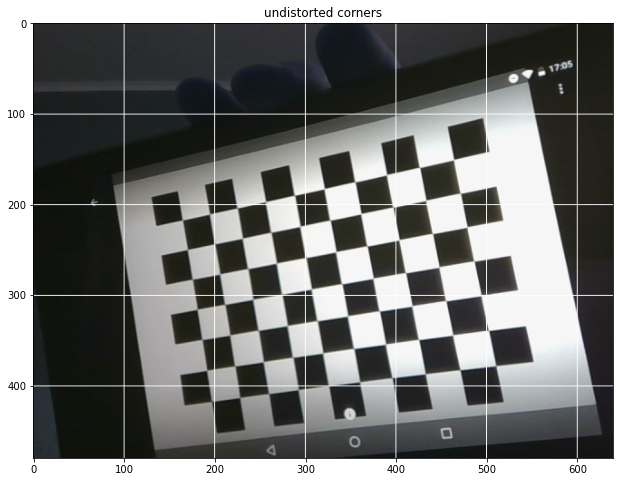

In [2]:
image_orig = cv2.imread('data/pinhole_calib/img_00.png')



#############################################################
print_image('data/pinhole_calib/img_00.png','image_orig',image_orig,0,2,0,7)
plt_view_image(plt,[["undistorted corners", draw_grid(np.copy(image_orig),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

------  data/pinhole_calib/img_00.png    Shape(480, 640, 3) image_orig: uint8
[[44 44 44] [42 42 42] [42 42 42] [43 43 43] [41 45 49] [41 45 49] [43 47 48] ]
[[44 44 44] [44 44 44] [42 41 43] [43 42 45] [44 43 46] [44 43 46] [41 45 49] ]
------  cv2.undistort------------    Shape(480, 640, 3) image_undistort: uint8
[[43 43 43] [42 42 42] [42 42 43] [43 43 44] [41 45 49] [38 42 46] [36 39 41] ]
[[44 44 44] [43 43 44] [42 42 43] [43 42 45] [44 43 46] [44 43 46] [42 45 48] ]


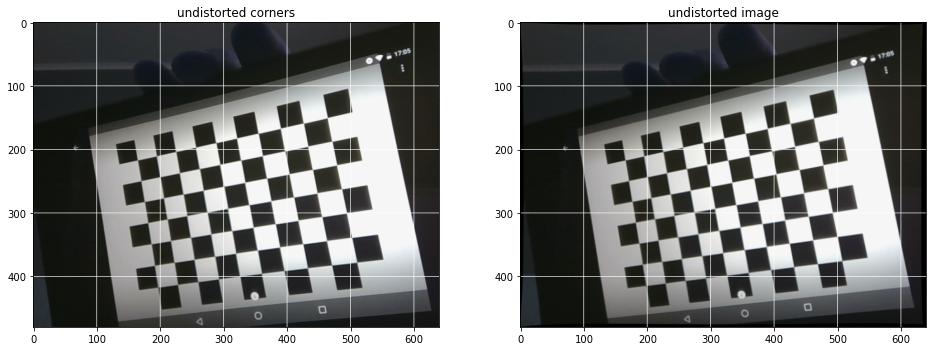

In [3]:
camera_matrix = np.load('data/pinhole_calib/camera_mat.npy')
dist_coefs = np.load('data/pinhole_calib/dist_coefs.npy')

image_undistort = cv2.undistort(image_orig, camera_matrix, dist_coefs)




#############################################################
print_image('data/pinhole_calib/img_00.png','image_orig',image_orig,0,2,0,7)
print_image('cv2.undistort','image_undistort',image_undistort,0,2,0,7)
plt_view_image(plt,[["undistorted corners", draw_grid(np.copy(image_orig),100,(255,255,255))],
                    ["undistorted image", draw_grid(np.copy(image_undistort),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

cv2.imshow('image_orig, undistorted image = cv2.undistort', 
           np.hstack([ draw_grid(np.copy(image_orig),100,(255,255,255)),
                       draw_grid(np.copy(image_undistort),100,(255,255,255))]))
cv2.waitKey()
cv2.destroyAllWindows()

------  data/pinhole_calib/img_00.png    Shape(480, 640, 3) image_orig: uint8
[[44 44 44] [42 42 42] [42 42 42] [43 43 43] [41 45 49] [41 45 49] [43 47 48] ]
[[44 44 44] [44 44 44] [42 41 43] [43 42 45] [44 43 46] [44 43 46] [41 45 49] ]
------  cv2.undistort------------    Shape(480, 640, 3) image_undistort: uint8
[[43 43 43] [42 42 42] [42 42 43] [43 43 44] [41 45 49] [38 42 46] [36 39 41] ]
[[44 44 44] [43 43 44] [42 42 43] [43 42 45] [44 43 46] [44 43 46] [42 45 48] ]
------  cv2.undistort------------    Shape(480, 640, 3) image_undistort: uint8
[[43 43 43] [42 42 42] [42 42 43] [43 43 44] [41 45 49] [38 42 46] [36 39 41] ]
[[44 44 44] [43 43 44] [42 42 43] [43 42 45] [44 43 46] [44 43 46] [42 45 48] ]


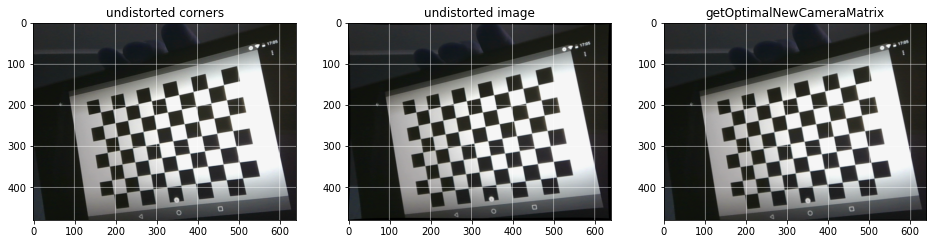

In [4]:
opt_cam_mat, valid_roi = cv2.getOptimalNewCameraMatrix(camera_matrix,
                                                       dist_coefs,image_orig.shape[:2][::-1],0)

image_opt_cam_mat = cv2.undistort(image_orig, camera_matrix, dist_coefs, None, opt_cam_mat)



#############################################################
print_image('data/pinhole_calib/img_00.png','image_orig',image_orig,0,2,0,7)
print_image('cv2.undistort','image_undistort',image_undistort,0,2,0,7)
print_image('cv2.undistort','image_undistort',image_undistort,0,2,0,7)
plt_view_image(plt,[["undistorted corners", draw_grid(np.copy(image_orig),100,(255,255,255))],
                    ["undistorted image", draw_grid(np.copy(image_undistort),100,(255,255,255))],
                    ["getOptimalNewCameraMatrix",draw_grid(np.copy(image_opt_cam_mat),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

cv2.imshow('image_orig, undistorted image = cv2.undistort', 
           np.hstack([draw_grid(np.copy(image_undistort),100,(255,255,255)),
                      draw_grid(np.copy(image_opt_cam_mat),100,(255,255,255))]))
cv2.waitKey(0)
cv2.destroyAllWindows()